In [4]:
import sys
from pathlib import Path
# Get the repository root (1 levels up from current notebook)
repo_root = Path(__file__).parent.parent if '__file__' in globals() else Path.cwd().parent
sys.path.insert(0, str(repo_root))

# import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, mean_absolute_error, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
import Template
# Definición de modulos
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling  import SMOTE, ADASYN
from sklearn.decomposition import PCA

# Instantiate the Template class
Template = Template.Template()

# Build the path to the Excel file in the repository root
data_path = os.path.join(repo_root, 'Cleaned_Resumen_datos_completos_Rev_final.xlsx')
# import the data from all sheets of the Excel file


df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15 = [
    pd.read_excel(data_path, sheet_name=i) for i in range(16)
]

df_concatenation = pd.concat([df0, df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15], ignore_index=True)

In [5]:
# Now let's make a generalization and collect all magnitudes in one dataframe

# Initialize an empty list to collect all magnitude rows
all_magnitudes = []

for treatment in df_concatenation['Tratamiento'].unique():
    df_treat = df_concatenation[df_concatenation['Tratamiento'] == treatment]
    for plant_num in df_treat['Planta'].unique():
        df_plant = df_treat[df_treat['Planta'] == plant_num]
        
        # Extract the relevant columns (from column 2 onwards)
        data_cols = df_plant.iloc[:, 2:]

        # Calculate the magnitude for each column
        magnitudes = []

        for col in data_cols.columns:
            # Get the column values
            values = data_cols[col].values
            
            # Take the first value as reference (x)
            x = values[0]
            
            # Calculate |y-x|/x, |z-x|/x, etc. for all other values
            if x != 0:  # Avoid division by zero
                differences = np.abs(values[1:] - x) / x
                # Calculate the magnitude (Euclidean norm)
                magnitude = np.sqrt(np.sum(differences**2))
            else:
                magnitude = np.nan  # Handle zero reference value
            
            magnitudes.append(magnitude)

        # Create a row with treatment and plant info plus magnitudes
        row_data = {'Tratamiento': treatment, 'Planta': plant_num}
        row_data.update({col: mag for col, mag in zip(data_cols.columns, magnitudes)})
        
        all_magnitudes.append(row_data)

# Create the final dataframe with all magnitudes
df_all_magnitudes = pd.DataFrame(all_magnitudes)

# Display the result
print(f"Final shape: {df_all_magnitudes.shape}")
print(f"Treatments: {df_all_magnitudes['Tratamiento'].unique()}")
print(f"Number of plants: {len(df_all_magnitudes)}")
df_all_magnitudes.head()

Final shape: (120, 2153)
Treatments: ['Control' 'Ralstonia' 'E_Hidrico' 'Ral_EH']
Number of plants: 120


,Tratamiento,Planta,350,351,352,353,354,355,356,357,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,Control,1.0,1.021843,0.918637,1.519278,1.277392,0.904435,0.812199,1.096020,1.663502,...,0.855917,0.861240,0.872555,0.877173,0.873784,0.874682,0.876456,0.877630,0.878478,0.879279
1,Control,2.0,0.744221,0.630094,1.100510,0.839847,0.559769,0.558418,0.691491,0.914094,...,0.555346,0.558121,0.560458,0.564561,0.565705,0.570400,0.580556,0.584151,0.584931,0.586789
2,Control,3.0,1.261811,1.056971,1.362683,1.069674,0.884345,0.926019,0.962112,1.166642,...,0.486347,0.487710,0.485979,0.487259,0.486004,0.490879,0.503218,0.506998,0.510770,0.510975
3,Control,4.0,1.930988,1.987898,2.394407,1.635587,1.113455,1.102211,1.529972,2.088282,...,0.508178,0.510385,0.512827,0.515902,0.522027,0.523876,0.524036,0.526655,0.527225,0.530205
4,Control,5.0,0.834535,0.908082,1.266780,0.960556,0.685252,0.699123,0.957407,1.120376,...,0.506864,0.508099,0.501217,0.502116,0.507893,0.508376,0.509787,0.509433,0.503680,0.502982


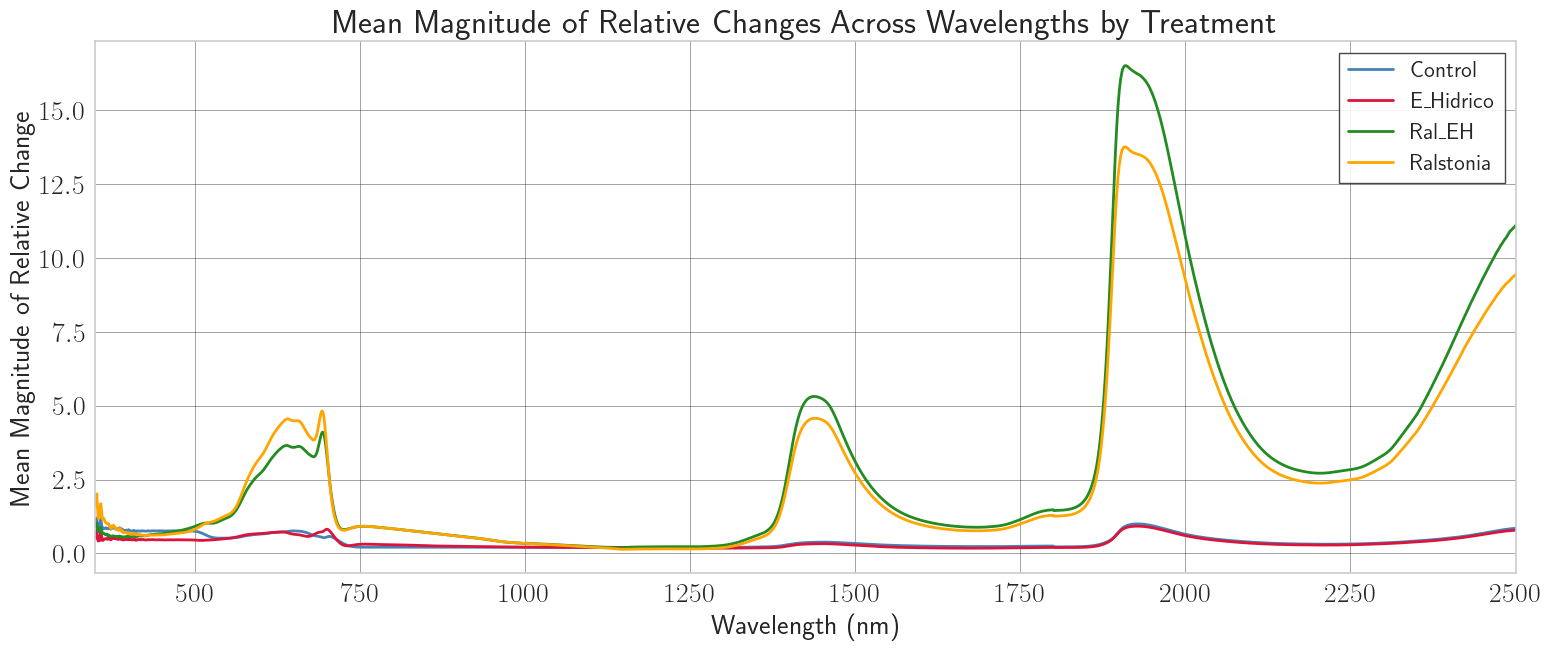

In [7]:
# now plots per treatment

# Lets make the mean of each wavelength magnitude per treatment
mean_magnitudes_per_treatment = df_all_magnitudes.groupby('Tratamiento').mean(numeric_only=True).reset_index()

# Extract wavelength column names (all numeric columns except 'Planta')
wavelengths = df_all_magnitudes.columns[2:].astype(float)

mean_magnitudes_per_treatment.head()

# Plot all treatments in one figure with different colors
plt.figure(figsize=(16, 7))

# Define colors for each treatment
colors = ['steelblue', 'crimson', 'forestgreen', 'orange', 'purple', 'brown', 'pink', 'gray']

for idx, treatment in enumerate(mean_magnitudes_per_treatment['Tratamiento']):
    df_treat_mean = mean_magnitudes_per_treatment[mean_magnitudes_per_treatment['Tratamiento'] == treatment]
    
    # Get magnitude values for this treatment
    magnitudes_values = df_treat_mean[wavelengths].values.flatten()
    
    # Plot line for this treatment
    plt.plot(wavelengths, magnitudes_values, linewidth=2, 
             label=treatment, color=colors[idx % len(colors)])

plt.xlabel('Wavelength (nm)', fontsize=20)
plt.ylabel('Mean Magnitude of Relative Change', fontsize=20)
plt.title('Mean Magnitude of Relative Changes Across Wavelengths by Treatment', fontsize=24, fontweight='bold')
plt.grid(True, alpha=0.5)
plt.xlim(wavelengths.min(), wavelengths.max())
plt.legend(fontsize=16, loc='best')
plt.tight_layout()
plt.show()